# SentiMeal Infering

This notebook contains code for infering predictions from a model (trained on YELP dataset) on restaurants from Graz

In [10]:
%%capture
!pip install datasets transformers huggingface_hub

In [11]:
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import re

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

sns.set_theme(style="whitegrid")
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
df = pd.read_csv("/content/drive/MyDrive/IUI/graz_reviews_restaurants.csv")
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date,sentiment,prob_neg,prob_pos
0,0x476e357f4a65a32f:0x699e717c59ba762d,El Pescador,https://www.google.com/maps/place/El+Pescador/...,Graz,Styria,8010,"47.070183799999995,15.4389313,14z/data=!4m8!1m...",15.438931,4.5,NaN,"Restaurants, Graz 8010",Lisa Pichler,1.0,Leider sehr wenig Platz an den Tischen. Empfan...,11/13/2022 10:00:59,0.0,0.997391,0.011720
1,0x476e357f4a65a32f:0x699e717c59ba762d,El Pescador,https://www.google.com/maps/place/El+Pescador/...,Graz,Styria,8010,"47.070183799999995,15.4389313,14z/data=!4m8!1m...",15.438931,4.5,NaN,"Restaurants, Graz 8010",Robin Hofer,5.0,Wirklich tolles Fischlokal. Esse gerne das Mit...,10/05/2022 06:57:03,2.0,0.006246,0.994457
2,0x476e357f4a65a32f:0x699e717c59ba762d,El Pescador,https://www.google.com/maps/place/El+Pescador/...,Graz,Styria,8010,"47.070183799999995,15.4389313,14z/data=!4m8!1m...",15.438931,4.5,NaN,"Restaurants, Graz 8010",Thomas Czerwinka,4.0,Top Fischrestaurant in Graz. Service sowie Ess...,10/02/2022 16:39:59,2.0,0.006976,0.994237
3,0x476e357f4a65a32f:0x699e717c59ba762d,El Pescador,https://www.google.com/maps/place/El+Pescador/...,Graz,Styria,8010,"47.070183799999995,15.4389313,14z/data=!4m8!1m...",15.438931,4.5,NaN,"Restaurants, Graz 8010",Hannes Wagner,5.0,Sehr gute Fischsuppe und ausgezeichnete Auster...,11/22/2022 10:06:29,2.0,0.005229,0.994455
4,0x476e357f4a65a32f:0x699e717c59ba762d,El Pescador,https://www.google.com/maps/place/El+Pescador/...,Graz,Styria,8010,"47.070183799999995,15.4389313,14z/data=!4m8!1m...",15.438931,4.5,NaN,"Restaurants, Graz 8010",sigwald,1.0,ein schönes Lokal mit größtenteils zu engen Ti...,10/09/2022 08:41:11,0.0,0.918190,0.007670


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

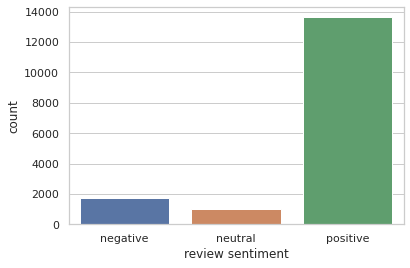

In [13]:
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

In [14]:
labels = df["sentiment"].to_list()
reviews = df["text"].to_list()

Load model and infer

In [15]:
from transformers import DistilBertForSequenceClassification
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/IUI/model_15k")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [16]:
sigmoid = nn.Sigmoid()
def get_prob(test_encoding):
  input_ids = torch.tensor(test_encoding["input_ids"]).to(device)
  attention_mask = torch.tensor(test_encoding["attention_mask"]).to(device)
  with torch.no_grad():
    outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
  y = np.argmax(outputs[0].to("cpu").numpy())
  sigmoid_vector = sigmoid(outputs.logits).to("cpu").numpy()[0]
  return y, sigmoid_vector[0], sigmoid_vector[2]

In [17]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [18]:
y_pred = []
prob_neg_list = []
prob_pos_list = []
for i in df["text"]:
  test_encoding = tokenizer(i, truncation=True, padding=True)
  input_ids = torch.tensor(test_encoding["input_ids"]).to(device)
  attention_mask = torch.tensor(test_encoding["attention_mask"]).to(device)
  y, prob_neg, prob_pos = get_prob(test_encoding)
  y_pred.append(y)
  prob_neg_list.append(prob_neg)
  prob_pos_list.append(prob_pos)

In [19]:
df["prob_neg"] = prob_neg_list
df["prob_pos"] = prob_pos_list

              precision    recall  f1-score   support

    negative       0.79      0.78      0.78      1745
     neutral       0.21      0.69      0.32       979
    positive       0.99      0.82      0.90     13642

    accuracy                           0.81     16366
   macro avg       0.66      0.76      0.67     16366
weighted avg       0.92      0.81      0.85     16366

[[ 1358   363    24]
 [  192   678   109]
 [  171  2247 11224]]


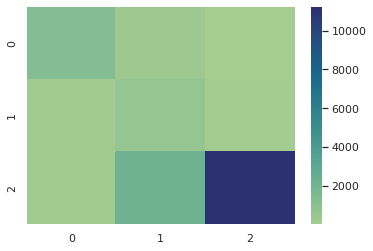

In [20]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

y_true = df["sentiment"].to_list()

target_names = ['negative', 'neutral', 'positive']
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred), cmap="crest")